In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(14, 7)

# hustle stat - average mph, miles run, balls deflected, contested shots, stats per minute (steals, o rebounds, feet), 
# jump balls, Loose balls recovered, boxouts, screen assists, charges, team, average salary, all nba or all star teams 
# https://stats.nba.com/players/speed-distance/?sort=AVG_SPEED&dir=1

# To do:
# 1) change the way calculate hustle score 
#        a) per minute 
#        b) add in distance and speed (https://stats.nba.com/players/speed-distance/?sort=DIST_MILES_DEF&dir=1&Season=2017-18&SeasonType=Regular%20Season)
#        c) standardize or not needed?
# 2) change up scatter plots 
# 3) multiple webdrivers at once? possible? good idea?
# 4) sort by position
# 5) trends over time - playoff teams, non-playoff teams, championship teams
# 6) predict current season outcomes

# GP >= 40 make sure not for current season



In [45]:
def getHustleStats(year):
    return getYearStats("https://stats.nba.com/players/hustle/?sort=MIN&dir=-1&Season=" + year + "&SeasonType=Regular%20Season", year)

def getRegularStats(year):
    return getYearStats("https://stats.nba.com/leaders/?Season=" + year + "&SeasonType=Regular%20Season", year)

def getYearStats(url, year):
    # Use an automated browser so that the webpage is rendered properly
    browser = webdriver.Safari()
    browser.get(url)
    
    # Edit HTML so that we can get the whole table
    browser.execute_script('document.getElementsByClassName("stats-table-pagination__select")[0].setAttribute("id", "btn")')
    browser.execute_script('document.getElementById("btn").children[0].setAttribute("id", "select-all")')
    nextButton = browser.find_element_by_id('btn')
    allButton = browser.find_element_by_id('select-all')
    
    # Click on buttons to get whole table
    nextButton.click()
    allButton.click()
    
    # Get HTML and parse
    innerHTML = browser.execute_script("return document.body.innerHTML")
    root = BeautifulSoup(innerHTML, "lxml")
    table = pd.read_html(str(root.find("table")))
    table = table[0]
    
    # Add year column for later table merging
    table['year'] = year
    browser.close()
    return table

In [49]:
table16_17 = getHustleStats("2016-17")
table17_18 = getHustleStats("2017-18")

In [51]:
table = table16_17.append(table17_18)
table.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year
0,"Danuel House, Jr.",WAS,24,1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
1,John Lucas III,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
2,Larry Sanders,CLE,28,5,2.5,0.2,0.4,0.2,0.0,0.0,0.2,0.0,0.0,0.0,1.4,0.0,1.4,2016-17
3,Steve Novak,MIL,34,8,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.5,2016-17
4,Brice Johnson,LAC,23,3,3.1,0.3,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.3,1.7,2016-17


In [47]:
test = getRegularStats("2016-17")
test.head()

,#,Player,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,year
0,1,Russell Westbrook,81,34.6,31.6,10.2,24.0,42.5,2.5,7.2,...,84.5,1.7,9.0,10.7,10.4,1.6,0.4,5.4,33.8,2016-17
1,2,James Harden,81,36.4,29.1,8.3,18.9,44.0,3.2,9.3,...,84.7,1.2,7.0,8.1,11.2,1.5,0.5,5.7,32.4,2016-17
2,3,Isaiah Thomas,76,33.8,28.9,9.0,19.4,46.3,3.2,8.5,...,90.9,0.6,2.1,2.7,5.9,0.9,0.2,2.8,24.7,2016-17
3,4,Anthony Davis,75,36.1,28.0,10.3,20.3,50.5,0.5,1.8,...,80.2,2.3,9.5,11.8,2.1,1.3,2.2,2.4,31.1,2016-17
4,5,DeMar DeRozan,74,35.4,27.3,9.7,20.9,46.7,0.4,1.7,...,84.2,0.9,4.3,5.2,3.9,1.1,0.2,2.4,22.7,2016-17


Cleaning the table: First, we delete any players who do not average 15 minutes per game.  Then we drop columns that we will not be using. 

In [28]:
table = table[table['MIN'] >= 15] # Delete players who did not average 15 minutes per game 
table = table[table['GP'] >= 40] # Delete players who did not play 40 games 
# Drop unused columns 
table = table.drop(['ScreenAssists PTS', 'OFF Loose BallsRecovered', 'DEF Loose BallsRecovered', '% Loose BallsRecovered OFF', '% Loose BallsRecovered DEF'], axis=1)
# table = table.drop(['Contested2PT Shots', 'Contested3PT Shots'], axis=1) # not sure why this isn't working 
table.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year
157,Alan Williams,PHX,24,47,15.1,2.1,1.0,0.6,0.00,5.7,0.9,6.6,2016-17
158,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17
161,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17
163,Alec Burks,UTA,25,42,15.5,0.1,0.8,0.4,0.00,1.6,1.4,3.0,2016-17
164,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17


In order to calculate our hustle score, we will use the sum of screen assists, deflections, loose balls recovered, charges drawn, and contested shots.  However, if we just took the sum of those statistics for each player, certain statistics, such as contested shots, would effect the overall hustle score more than others because its numbers are generally higher.  Therefore, we decided to normalize each statistic by dividing its value by the max for that specific statistic.  

In [20]:
maxScreenAssists = (table['ScreenAssists']/table['MIN']).max()
maxDeflections = (table['Deflections']/table['MIN']).max()
maxLooseBallsRecovered = (table['Loose BallsRecovered']/table['MIN']).max()
maxChargesDrawn = (table['ChargesDrawn']/table['MIN']).max()
maxContestedShots = (table['ContestedShots']/table['MIN']).max()
print("maxScreenAssists per minute: " + str(maxScreenAssists))
print("maxDeflections per minute: " + str(maxDeflections))
print("maxLooseBallsRecovered per minute: " + str(maxLooseBallsRecovered))
print("maxChargesDrawn per minute: " + str(maxChargesDrawn))
print("maxContestedShots per minute: " + str(maxContestedShots))

# avgScreenAssists = table['ScreenAssists'].mean()
# stdScreenAssists = table['ScreenAssists'].std()
# avgDeflections = table['Deflections'].mean()
# stdDeflections = table['Deflections'].std()
# avgLooseBallsRecovered = table['Loose BallsRecovered'].mean()
# stdLooseBallsRecovered = table['Loose BallsRecovered'].std()
# avgChargesDrawn = table['ChargesDrawn'].mean()
# stdChargesDrawn = table['ChargesDrawn'].std()
# avgContestedShots = table['ContestedShots'].mean()
# stdContestedShots = table['ContestedShots'].std()

maxScreenAssists per minute: 0.21223021582733814
maxDeflections per minute: 0.13291139240506328
maxLooseBallsRecovered per minute: 0.06046511627906977
maxChargesDrawn per minute: 0.026114649681528664
maxContestedShots per minute: 0.5750000000000001


In [39]:
# table['HustleScore'] = table['ScreenAssists']/maxScreenAssists + table['Deflections']/maxDeflections + table['Loose BallsRecovered']/maxLooseBallsRecovered + table['ChargesDrawn']/maxChargesDrawn + table['ContestedShots']/maxContestedShots
table['HustleScore'] = (table['ScreenAssists']/maxScreenAssists + table['Deflections']/maxDeflections + table['Loose BallsRecovered']/maxLooseBallsRecovered + table['ChargesDrawn']/maxChargesDrawn + table['ContestedShots']/maxContestedShots)/(table['MIN'])
table.head()
# win_perc_salary_table['standardized_payroll'] = (win_perc_salary_table['payroll'] - win_perc_salary_table['avg_payroll'])/win_perc_salary_table['std_payroll']

,Player,TEAM,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,HustleScore,year
267,Jakob Poeltl,TOR,22,82,19,2.8,1.0,0.7,0.05,8.5,1.5,9.9,2.906331,2017-2018
287,Jarrett Allen,BKN,20,72,20,2.2,0.8,0.7,0.00,9.7,1.3,11.0,2.488255,2017-2018
487,Rudy Gobert,UTA,26,56,32,6.2,1.5,0.8,0.00,12.8,2.3,15.0,2.659965,2017-2018
280,Alex Len,PHX,25,69,20,3.8,0.8,0.5,0.00,8.1,1.1,9.3,2.577382,2017-2018
333,Brook Lopez,LAL,30,74,23,2.1,1.0,0.5,0.00,10.1,2.5,12.6,2.191933,2017-2018


In [42]:
# Sort table by HustleScore
table = table.sort_values(by=['HustleScore'],ascending=False)
table['year'] = '2017-2018'
table.head(30)

,Player,TEAM,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,HustleScore,year
227,Gorgui Dieng,MIN,28,79,17,1.7,1.3,0.8,0.18,4.9,1.8,6.7,3.231985,2017-2018
530,DeMarcus Cousins,NOP,27,48,36,2.3,2.7,1.6,0.50,10.7,2.7,13.3,3.123819,2017-2018
365,Ersan Ilyasova,PHI,31,69,25,1.8,1.7,0.9,0.46,4.6,2.2,6.8,3.033338,2017-2018
346,Kelly Olynyk,MIA,27,76,23,2.7,1.9,0.8,0.20,5.7,2.1,7.8,2.961525,2017-2018
201,Amir Johnson,PHI,31,74,16,2.5,1.0,0.7,0.08,4.7,0.8,5.5,2.956396,2017-2018
267,Jakob Poeltl,TOR,22,82,19,2.8,1.0,0.7,0.05,8.5,1.5,9.9,2.906331,2017-2018
304,Dwight Powell,DAL,26,79,21,2.1,1.7,0.9,0.09,5.5,3.1,8.6,2.883136,2017-2018
271,Mason Plumlee,DEN,28,74,19,2.0,1.7,0.7,0.09,5.7,1.5,7.2,2.847351,2017-2018
196,Nene,HOU,35,52,15,2.0,1.4,0.5,0.04,3.5,1.9,5.4,2.817560,2017-2018
489,Thaddeus Young,IND,30,81,32,1.3,3.6,1.5,0.17,5.8,4.7,10.5,2.811337,2017-2018


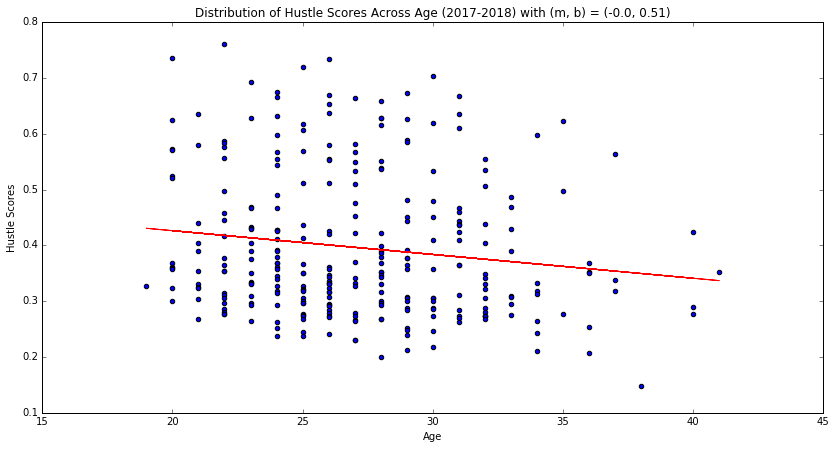

In [26]:
scatter = table.plot.scatter('AGE', 'HustleScore')

(m, b) = np.polyfit(table['AGE'], table['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in table['AGE']]
scatter.plot(table['AGE'], regression_line, color='red') 

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Age (2017-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Age")
scatter.set_ylabel("Hustle Scores")

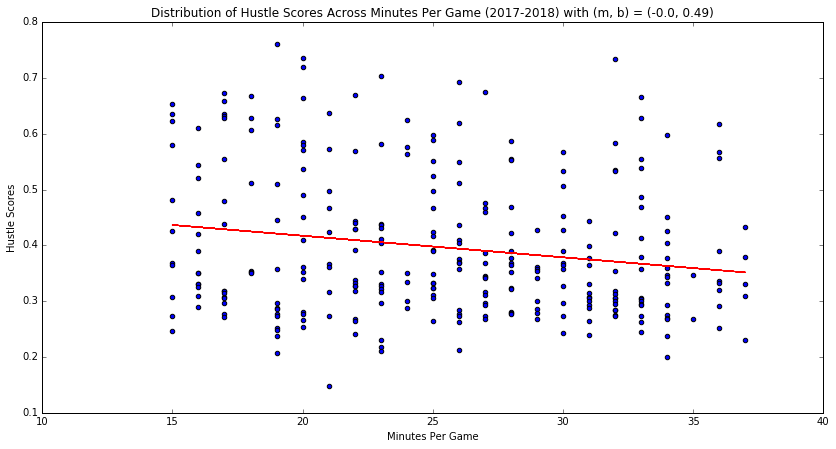

In [27]:
scatter = table.plot.scatter('MIN', 'HustleScore')

(m, b) = np.polyfit(table['MIN'], table['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in table['MIN']]
scatter.plot(table['MIN'], regression_line, color='red') 

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Minutes Per Game (2017-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Minutes Per Game")
scatter.set_ylabel("Hustle Scores")

In [28]:
teamHustleTable = pd.DataFrame(table.groupby('TEAM')['HustleScore'].sum())
teamHustleTable = teamHustleTable.sort_values(by=['HustleScore'],ascending=False)
teamHustleTable = teamHustleTable.reset_index()
teamHustleTable.head()

,TEAM,HustleScore
0,PHI,4.636061
1,CHI,4.625460
2,BOS,4.595292
3,TOR,4.434974
4,CLE,4.269806


In [29]:
teamWinsTable = pd.read_csv('teams_2017_2018.csv')
teamWinsTable.columns = ['0', 'TEAM', 'Wins', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
teamWinsTable.head(8)

,0,TEAM,Wins,2,3,4,5,6,7,8,9,10,11,12
0,Official NBA Conference Overall Standings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Eastern Conference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Team,W,L,Win%,GB,Conf,Div,Home,Road,OT,Last 10,Streak,NaN
5,1,TOR,59,23,0.72,0,40-12,12-4,34-7,25-16,4-2,6-4,L 1,NaN
6,2,BOS,55,27,0.671,4,33-19,12-4,27-14,28-13,2-2,6-4,W 1,NaN
7,3,PHI,52,30,0.634,7,34-18,9-7,30-11,22-19,1-1,10-0,W 16,NaN


In [30]:
teamWinsTable = teamWinsTable.drop(teamWinsTable.index[0]).drop(teamWinsTable.index[1]).drop(teamWinsTable.index[2]).drop(teamWinsTable.index[3]).drop(teamWinsTable.index[4])
teamWinsTable = teamWinsTable.drop(['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], axis=1)
teamWinsTable.head(8)

,TEAM,Wins
5,TOR,59
6,BOS,55
7,PHI,52
8,CLE,50
9,IND,48
10,MIA,44
11,MIL,44
12,WAS,43


In [31]:
teamTable = pd.merge(teamHustleTable, teamWinsTable, on=['TEAM'])
teamTable.head()

,TEAM,HustleScore,Wins
0,PHI,4.636061,52
1,CHI,4.625460,27
2,BOS,4.595292,55
3,TOR,4.434974,59
4,CLE,4.269806,50


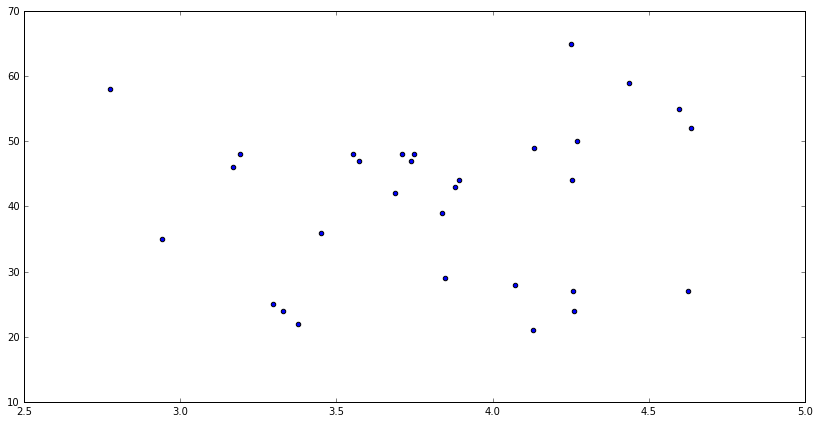

In [32]:
#plt.scatter(x=teamTable['HustleScore'], y=teamTable['Wins'])
x = teamTable['HustleScore']
y = teamTable['Wins']
fig, ax = plt.subplots()
ax.scatter(x, y) # try to switch x and y here

# (m, b) = np.polyfit(teamTable['HustleScore'], teamTable['Wins'], 1)
# # Calculate the actual best fit line 
# regression_line = [(m*x)+b for x in teamTable['HustleScore']]
# scatter.plot(teamTable['HustleScore'], regression_line, color='red') 

# # Label the plot
# scatter.set_title("Distribution of Hustle Scores Across Team Wins (2017-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
# ax.set_xlabel("Team Hustle Score")
# ax.set_ylabel("Team Wins")

# scatter = teamTable.plot.scatter('Wins', 'HustleScore')
# # Label the plot
# scatter.set_title("Distribution of Hustle Scores Across Team Wins (2017-2018)")
# scatter.set_xlabel("Team Wins")
# scatter.set_ylabel("Team Hustle Score")

In [237]:
browser.close()